<h1>Model: Male Fear vs. Others</h1>

In [1]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

/home/team3/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/team3/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/team3/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/team3/anaconda3/envs/gpu/lib/python3.7/site-packages

In [2]:
import keras
import pandas as pd
import tensorflow as tf

import numpy as np
# from keras.models import Sequential, Model
# from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import np_utils

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D, Input,AveragePooling2D, BatchNormalization, LeakyReLU, SpatialDropout2D

# from keras.applications import MobileNet
# from keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, InceptionV3
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt
import os
from sklearn.model_selection import train_test_split

import seaborn as sns
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import KFold

from collections import defaultdict
from PIL import Image

Using TensorFlow backend.


<h2>Data Loading and Preparation</h2>

In [3]:
def getEmotionCode(x):
    part = x.split('_')
    if part[3] == 'FEA':
        return 1
    else:
        return 0

def getEmotion(x):
    if x == 1:
        return 'FEA'
    else:
        return 'OTH'

In [4]:
X_all = []
Y_all = []

image_folder_path = 'cremad/SpectogramInitial'
file_paths = [f for f in os.listdir(image_folder_path)]

for file_name in file_paths:
    split_file_name = file_name.split('_')
    if split_file_name[0] == 'M':
        spectrogram = Image.open(image_folder_path + '/' + file_name)
        spectrogram = spectrogram.convert('RGB')
        spectrogram = spectrogram.resize((341, 224))
        spectrogram = np.array(spectrogram)
#         spectrogram = np.expand_dims(spectrogram, axis=2)
        X_all.append(spectrogram)
        Y_all.append(getEmotionCode(file_name))
    
# print(X_all)
# print(Y_all)


In [5]:
# print("Anger "+ Y_all.count('0'))
df=pd.DataFrame([getEmotion(f) for f in Y_all],columns=['Emotion'])
df['Emotion'].value_counts()

OTH    3259
FEA     671
Name: Emotion, dtype: int64

In [6]:
X_all = np.array(X_all)
Y_all = np.array(Y_all)

print(X_all.shape)
print(Y_all.shape)

X_all = X_all.astype('float32')
X_all /= 255

Y_all = np_utils.to_categorical(Y_all, num_classes=2)



(3930, 224, 341, 3)
(3930,)


In [7]:
# train /test= 80/20% split
# stratified
X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=0.2, stratify=Y_all)



<h2>Model Building</h2>

In [8]:
def build_current_model():
    inp = Input(shape=(224,341,3))
    
    lay = Convolution2D(filters=64,kernel_size=(5,5),strides=(2,2),padding='same')(inp)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = SpatialDropout2D(0.1)(lay)    
    lay = MaxPooling2D(pool_size=(2,2),strides=3,padding='same')(lay)
    
    lay = Convolution2D(filters=128,kernel_size=(3,3),strides=(2,2),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = SpatialDropout2D(0.15)(lay)    
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    
    lay = Convolution2D(filters=256,kernel_size=(3,3),strides=(2,2),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = SpatialDropout2D(0.2)(lay)    
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    
    lay = Convolution2D(filters=512,kernel_size=(5,5),strides=(2,2),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = SpatialDropout2D(0.25)(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    
    lay = Flatten()(lay)
    
    lay = Dense(128)(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('tanh')(lay)
    lay = Dropout(0.3)(lay)
    
    lay = Dense(512)(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('tanh')(lay)
    lay = Dropout(0.25)(lay)
    
    lay = Dense(1024)(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('tanh')(lay)
    lay = Dropout(0.1)(lay)

    x_out = Dense(2, name='output', activation='softmax')(lay)
    
    model = Model(inputs=inp, outputs=x_out)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), 
                  loss='categorical_crossentropy', 
                  metrics = ['accuracy'])
    return model


In [9]:
model = build_current_model()
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 341, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 112, 171, 64)      4864      
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 171, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 112, 171, 64)      0         
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 112, 171, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 38, 57, 64)        0         
_________

In [10]:
#tf.keras.utils.plot_model(model, "Model-Ref7Var.png", show_shapes=True)

In [11]:

my_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=15,verbose=1, mode='min',restore_best_weights=True)]

history = model.fit(X_train, Y_train, 
              epochs = 200, 
              validation_split=0.1, 
              verbose=1, 
              batch_size = 8,
            callbacks=my_callbacks)

history_info = history.history

Train on 2829 samples, validate on 315 samples
Epoch 1/200
2829/2829 [==============================] - 7s 3ms/sample - loss: 0.7222 - acc: 0.7105 - val_loss: 0.5639 - val_acc: 0.7587
Epoch 2/200
2829/2829 [==============================] - 6s 2ms/sample - loss: 0.5197 - acc: 0.7907 - val_loss: 1.0945 - val_acc: 0.1619
Epoch 3/200
2829/2829 [==============================] - 6s 2ms/sample - loss: 0.5166 - acc: 0.7922 - val_loss: 0.4945 - val_acc: 0.8032
Epoch 4/200
2829/2829 [==============================] - 6s 2ms/sample - loss: 0.5216 - acc: 0.7960 - val_loss: 0.7296 - val_acc: 0.5873
Epoch 5/200
2829/2829 [==============================] - 6s 2ms/sample - loss: 0.4957 - acc: 0.8070 - val_loss: 0.4469 - val_acc: 0.8444
Epoch 6/200
2829/2829 [==============================] - 6s 2ms/sample - loss: 0.4735 - acc: 0.8183 - val_loss: 0.4222 - val_acc: 0.8444
Epoch 7/200
2829/2829 [==============================] - 6s 2ms/sample - loss: 0.4890 - acc: 0.8105 - val_loss: 0.4851 - val_acc: 0

<h2>Evaluation (Basic)</h2>

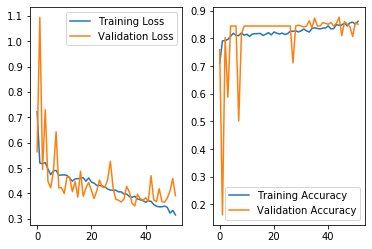

In [12]:
## Loss and accuracy history
_, axs = plt.subplots(ncols=2)
df_history_info = pd.DataFrame(history_info) 


sns.lineplot(data=df_history_info['loss'],ax=axs[0], label='Training Loss', legend='brief')
sns.lineplot(data=df_history_info['val_loss'],ax=axs[0], label='Validation Loss', legend='brief')

sns.lineplot(data=df_history_info['acc'],ax=axs[1], label='Training Accuracy', legend='brief')
sns.lineplot(data=df_history_info['val_acc'],ax=axs[1], label='Validation Accuracy', legend='brief')

In [13]:
def generate_actual_predicted(Y_pred, X_test, Y_test): 
    predicted = list()
    for i in range(len(Y_pred)):
        predicted.append(np.argmax(Y_pred[i]))
        
    actual = list()
    for i in range(len(Y_test)):
        actual.append(np.argmax(Y_test[i]))
        
    return actual, predicted

[[ 29 105]
 [ 26 626]]


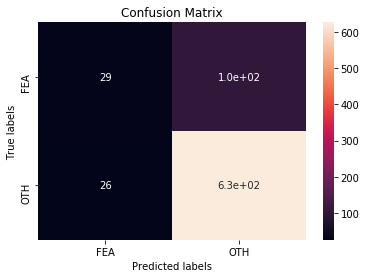

In [14]:
Y_pred = model.predict(X_test)
actual, predicted = generate_actual_predicted(Y_pred, X_test, Y_test)

##Confusion Matrix
from sklearn.metrics import confusion_matrix
actual_labeled = list()
predict_labeled = list()
for x,y in zip(actual,predicted):
    actual_labeled.append(getEmotion(x))
    predict_labeled.append(getEmotion(y))

labels = ['FEA','OTH']
cm=confusion_matrix(actual_labeled,predict_labeled,labels=labels)
print(cm)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);

In [15]:
## Test accuracy
from sklearn.metrics import accuracy_score
print('accuracy', accuracy_score(actual, predicted))


accuracy 0.8333333333333334


In [16]:
## Precision, Recall, F1, Support
from sklearn.metrics import classification_report
print(classification_report(actual_labeled, predict_labeled,labels=labels))

              precision    recall  f1-score   support

         FEA       0.53      0.22      0.31       134
         OTH       0.86      0.96      0.91       652

    accuracy                           0.83       786
   macro avg       0.69      0.59      0.61       786
weighted avg       0.80      0.83      0.80       786



In [17]:
##ROC AUC Scores
#from sklearn.metrics import roc_auc_score
#print('One-vs-One ROC AUC scores:')
#print(roc_auc_score(actual, Y_pred, average='macro', multi_class='ovo'), '(macro)')
#print(roc_auc_score(actual, Y_pred, average='weighted', multi_class='ovo'), '(weighted by prevalence)')


#print()
#print('One-vs-Rest ROC AUC scores:')
#print(roc_auc_score(actual, Y_pred, average='macro', multi_class='ovr'), '(macro)')
#print(roc_auc_score(actual, Y_pred, average='weighted', multi_class='ovr'), '(weighted by prevalence)')

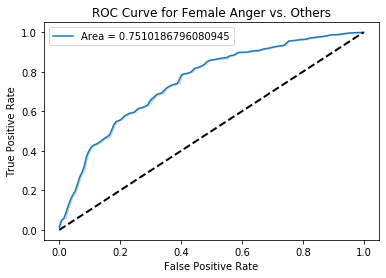

In [18]:
## ROC Curves
from sklearn.metrics import roc_curve, auc
import seaborn as sns
from scipy import interp

### The following curves are generated s.t each point is a model from differing thresholds

_, axs = plt.subplots(ncols=1)
axs.set(xlabel='False Positive Rate',ylabel='True Positive Rate', title='ROC Curve for Female Anger vs. Others')


fpr, tpr, _ = roc_curve(Y_test[:,0], Y_pred[:,0])
auc_val = auc(fpr, tpr)
sns.lineplot(x=fpr,y=tpr,ax=axs, label='Area = ' + str(auc_val) + '', legend='brief')


plt.plot([0, 1], [0, 1], 'k--', lw=2)

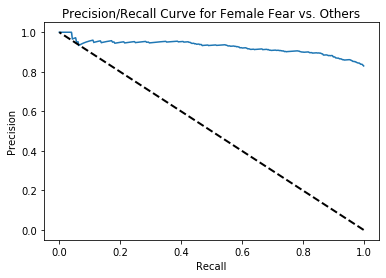

In [19]:
## Precision/Recall Curves per class
### The following curves are generated s.t each point is a model from differing thresholds
from sklearn.metrics import precision_recall_curve

_, axs = plt.subplots(ncols=1)
axs.set(xlabel='Recall',ylabel='Precision', title='Precision/Recall Curve for Female Fear vs. Others')

prec, rec, _ = precision_recall_curve(Y_test[:,0], Y_pred[:,0])
sns.lineplot(x=rec,y=prec,ax=axs)

# Diagonal line for comparison
plt.plot([1, 0], [0, 1], 'k--', lw=2)

<h2>K-Fold Training and Evaluation</h2>

In [20]:
#Precision Mean and Standard Deviation
#Recall Mean and Standard Deviation
#F1 Measure Mean and Standard Deviation
#True Positive Rate. Mean and Standard Deviation
#False Negative Rate Mean and Standard Deviation
#Best/Worst ROC
#Best/Worst Precision/Recall
#Accuracy Mean and Standard Deviation

In [21]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve

all_base_precision = list()
all_base_recall = list()
all_macro_precision = list()
all_macro_recall = list()
all_f1 = list()
all_macro_f1 = list()


all_tpr = list()
all_fpr = list()
all_precision = list()
all_recall = list()

all_accuracy = list()


n_split=3
for train_index,test_index in KFold(n_split).split(X_all):  
    # use the index to generate training an testing sets
    x_train,x_test=X_all[train_index],X_all[test_index]
    y_train,y_test=Y_all[train_index],Y_all[test_index]

    # create and fit the model
    cv_model=build_current_model()
    history = cv_model.fit(x_train, y_train,
              batch_size=8,
              epochs=30,
              validation_split=0.1,
              verbose=1)
    
    #generate predictions
    y_pred = cv_model.predict(x_test)
    actual, predicted = generate_actual_predicted(y_pred, x_test, y_test)
    
    #calc metrics
    curr_base_prec, curr_base_rec, curr_f1, _ = precision_recall_fscore_support(actual, predicted)
    curr_macro_prec = precision_score(actual, predicted,average='macro')
    curr_macro_rec = recall_score(actual, predicted,average='macro')
    curr_macro_f1 = f1_score(actual, predicted,average='macro')

    
    curr_fpr = [0] * 6
    curr_tpr = [0] * 6
    for i in range(6):
        curr_fpr[i], curr_tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
        
    curr_prec = [0] * 6
    curr_rec = [0] * 6
    for i in range(6):
        curr_prec[i], curr_rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])

        
    curr_accuracy = accuracy_score(actual, predicted)
    
    #add to lists
    all_base_precision.append(curr_base_prec)
    all_base_recall.append(curr_base_rec)
    all_macro_precision.append(curr_macro_prec)
    all_macro_recall.append(curr_macro_rec)
    
    all_f1.append(curr_f1)
    all_macro_f1.append(curr_macro_f1)
    
    all_accuracy.append(curr_accuracy)

    
    all_fpr.append(curr_fpr)
    all_tpr.append(curr_tpr)
    all_precision.append(curr_prec)
    all_recall.append(curr_rec)
    
    


Train on 2358 samples, validate on 262 samples
Epoch 1/30
2358/2358 [==============================] - 5s 2ms/sample - loss: 1.0594 - acc: 0.6569 - val_loss: 0.6497 - val_acc: 0.7099
Epoch 2/30
2358/2358 [==============================] - 5s 2ms/sample - loss: 0.5987 - acc: 0.7413 - val_loss: 0.4526 - val_acc: 0.8702
Epoch 3/30
2358/2358 [==============================] - 5s 2ms/sample - loss: 0.5380 - acc: 0.7799 - val_loss: 0.5195 - val_acc: 0.8359
Epoch 4/30
2358/2358 [==============================] - 5s 2ms/sample - loss: 0.5555 - acc: 0.7735 - val_loss: 0.4154 - val_acc: 0.8702
Epoch 5/30
2358/2358 [==============================] - 5s 2ms/sample - loss: 0.5228 - acc: 0.7829 - val_loss: 0.4408 - val_acc: 0.8702
Epoch 6/30
2358/2358 [==============================] - 5s 2ms/sample - loss: 0.5424 - acc: 0.7807 - val_loss: 0.4228 - val_acc: 0.8702
Epoch 7/30
1560/2358 [==================>...........] - ETA: 1s - loss: 0.5290 - acc: 0.7763

KeyboardInterrupt: 

In [ ]:
print('precision mean by class', np.array(all_base_precision).mean(axis=0))
print('precision sdev by class', np.array(all_base_precision).std(axis=0))

print('macro precision mean', np.array(all_macro_precision).mean())
print('macro precision sdev', np.array(all_macro_precision).std())


print('recall mean', np.array(all_base_recall).mean(axis=0))
print('recall sdev', np.array(all_base_recall).std(axis=0))

print('macro recall mean', np.array(all_macro_recall).mean())
print('macro recall sdev', np.array(all_macro_recall).std())

print('f1 mean', np.array(all_f1).mean(axis=0))
print('f1 sdev', np.array(all_f1).std(axis=0))

print('macro f1 mean', np.array(all_macro_f1).mean())
print('macro f1 sdev', np.array(all_macro_f1).std())

print('accuracy mean', np.array(all_accuracy).mean())
print('accuracy sdev', np.array(all_accuracy).std())



In [ ]:
# Plot all K-Fold ROC curves
for i in range(3):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='False Positive Rate',ylabel='True Positive Rate', title='ROC Curve K-Fold#'+str(i+1))
    for j in range(6):
        auc_val = auc(all_fpr[i][j], all_tpr[i][j])
        sns.lineplot(x=all_fpr[i][j],y=all_tpr[i][j],ax=axs, label='Class '+ getEmotion(j) +' (area = ' + str(auc_val) + ')', legend='brief')
        

In [ ]:
#Plot all K-Fold Precision/Recall curves
for i in range(3):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='Recall',ylabel='Precision', title='Precision/Recall Curve K-Fold#'+str(i+1))
    for j in range(6):
        sns.lineplot(x=all_recall[i][j],y=all_precision[i][j],ax=axs, label='Class '+ getEmotion(j), legend='brief')

<h2>Storing/Loading history and model to file</h2>

In [ ]:
#Store History
hist_df = pd.DataFrame(history.history) 
hist_json_file = 'ref7varhistory.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

In [ ]:
#Load History 
history_info = pd.read_json('history.json')

In [ ]:
##Save Model
model.save('ref7var_trained.model') #Save the model

In [ ]:
## Load Model
model = tf.keras.models.load_model('mobile_net_trained.model') #Re load model